<a href="https://colab.research.google.com/github/abatista346/Brazilian-E-Commerce-Analysis/blob/main/EDA_olistbr_brazilian_ecommerceV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Brazilian E-Commerce Analysis: Strategic Insights from Olist**


###**Executive Summary**
This project performs an End-to-End Exploratory Data Analysis (EDA) on the Brazilian E-Commerce public dataset by Olist. The goal is to transform raw transactional data into actionable business intelligence to support decision-making in logistics, sales, and product management.

###**Key Objectives**


*   **Data Reliability**: Implement robust data cleaning and vectorized preprocessing for high-performance analysis.
*   **Revenue Dynamics**: Identify growth trends and seasonal patterns in monthly revenue.
*   **Strategic Segmentation**: Apply the Pareto Principle (ABC Analysis) to categorize product departments by their revenue contribution.
*   **Operational Excellence**: Analyze order status and lifecycle to monitor business health.


###**Tech Stack**

*   **Data Manipulation**: Python (Pandas, NumPy)
*   **Visualization**: Seaborn, Matplotlib (Business-ready charts)
*   **Skills Demonstrated**: Feature Engineering, Method Chaining, Clean Code (PEP 8), and Business Intelligence.





##1. Setup & Data Loading

In [2]:
!pip install unidecode
!pip install kagglehub

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
import warnings

# Global settings for professional visualization
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

# Downloading the latest version of the Brazilian E-Commerce dataset (Olist)
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("Path to dataset files:", path)

# Loading datasets with descriptive naming conventions
orders = pd.read_csv(f'{path}/olist_orders_dataset.csv')
order_items = pd.read_csv(f'{path}/olist_order_items_dataset.csv')
customers = pd.read_csv(f'{path}/olist_customers_dataset.csv')
products = pd.read_csv(f'{path}/olist_products_dataset.csv')
payments = pd.read_csv(f'{path}/olist_order_payments_dataset.csv')

print("Datasets loaded successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.5 MB/s eta 0:00:00
Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Path to dataset files: /kaggle/input/brazilian-ecommerce
Datasets loaded successfully.


##2. Data Cleaning & Optimization

In [3]:
# Handling missing values in product categories
# We drop nulls in 'product_category_name' to ensure analysis accuracy
products_clean = products.dropna(subset=['product_category_name'])

# Professional Datetime Conversion
# Using a vectorized approach for efficiency (Best Practice)
date_cols = [
    'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
orders[date_cols] = orders[date_cols].apply(pd.to_datetime)

# Verifying data types after conversion
print(orders[date_cols].dtypes)

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


##3. Feature Engineering & Merging

In [4]:
# Merging datasets using Method Chaining for cleaner code
# This joins orders, items, and products into a single master dataframe
df = orders.merge(order_items, on='order_id') \
           .merge(products_clean, on='product_id')

# Extracting Time-based features for trend analysis
# Important: Creating features AFTER merge to avoid index misalignment
df['month_yr'] = df['order_purchase_timestamp'].dt.to_period('M')
df['day_of_week'] = df['order_purchase_timestamp'].dt.day_name()

print(f"Master dataframe created with shape: {df.shape}")

Master dataframe created with shape: (111047, 24)


##4. Advanced Business Intelligence (Pareto Analysis)

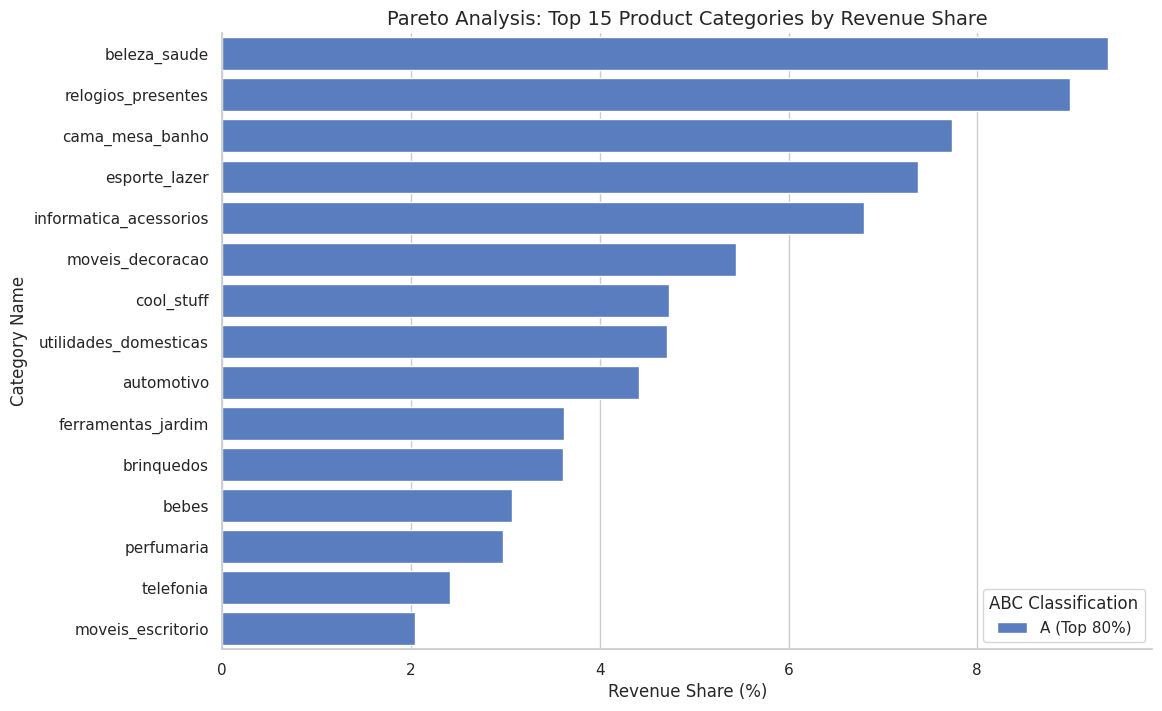

In [5]:
# Pareto Analysis (ABC Curve) by Product Category
# Focus: Identifying which categories drive 80% of the total revenue
cat_revenue = df.groupby('product_category_name')['price'].sum().sort_values(ascending=False).reset_index()

# Calculating cumulative percentage share
cat_revenue['revenue_share'] = (cat_revenue['price'] / cat_revenue['price'].sum()) * 100
cat_revenue['cumulative_share'] = cat_revenue['revenue_share'].cumsum()

# Categorizing into A, B, and C classes
def classify_abc(percentage):
    if percentage <= 80: return 'A (Top 80%)'
    elif percentage <= 95: return 'B (Medium 15%)'
    else: return 'C (Lower 5%)'

cat_revenue['abc_class'] = cat_revenue['cumulative_share'].apply(classify_abc)

# Visualization: Top 15 Categories by Revenue Share
plt.figure(figsize=(12, 8))
sns.barplot(data=cat_revenue.head(15), x='revenue_share', y='product_category_name', hue='abc_class', dodge=False)
plt.title('Pareto Analysis: Top 15 Product Categories by Revenue Share', fontsize=14)
plt.xlabel('Revenue Share (%)')
plt.ylabel('Category Name')
plt.legend(title='ABC Classification')
sns.despine()
plt.show()

##5. Revenue Trends Visualization

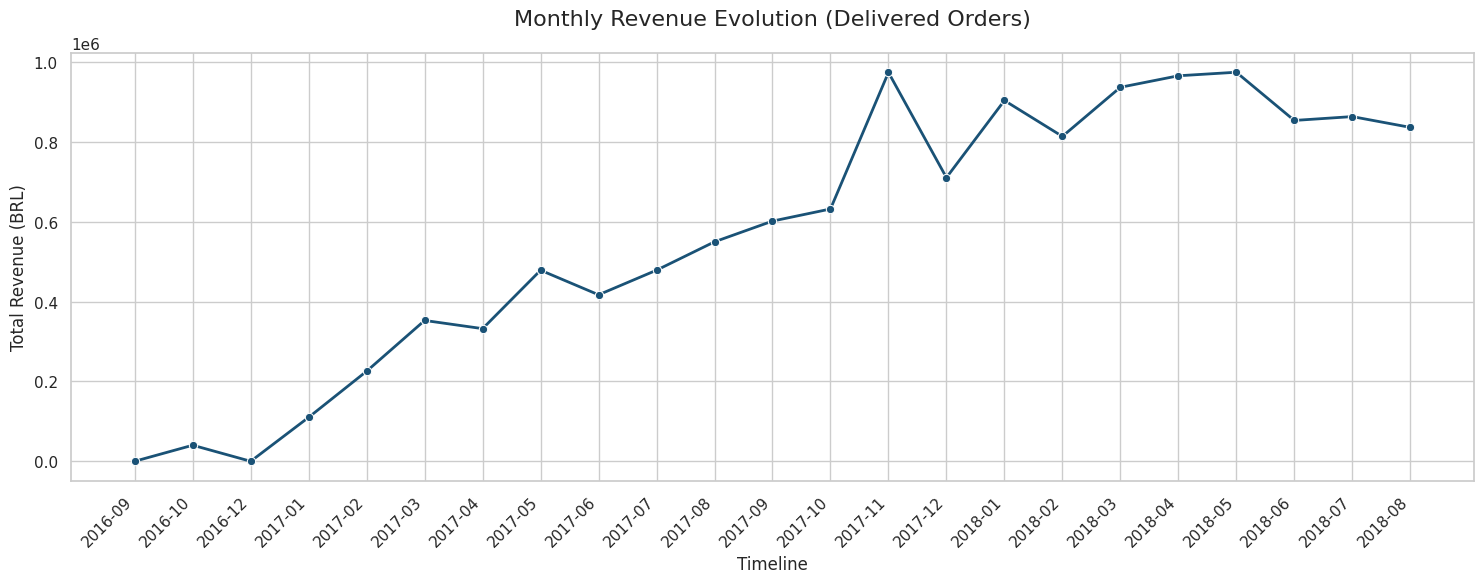

In [6]:
# Preparing monthly revenue data (Filtering only for 'delivered' orders)
monthly_revenue = df[df['order_status'] == 'delivered'].groupby('month_yr')['price'].sum().reset_index()
monthly_revenue['month_yr'] = monthly_revenue['month_yr'].astype(str)

# Professional Line Plot for Stakeholder Presentation
plt.figure(figsize=(15, 6))
sns.lineplot(data=monthly_revenue, x='month_yr', y='price', marker='o', linewidth=2, color='#1a5276')
plt.title('Monthly Revenue Evolution (Delivered Orders)', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Revenue (BRL)')
plt.xlabel('Timeline')
plt.tight_layout()
plt.show()

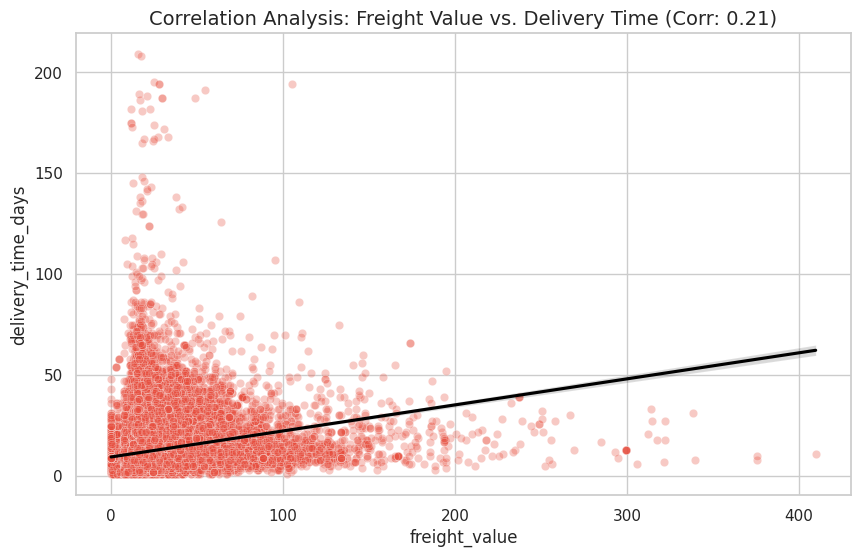

In [7]:
# 1. Calculating Delivery Time (Lead Time)
# We calculate the difference between purchase and actual delivery
df['delivery_time_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# 2. Filtering relevant data to avoid outliers in correlation
# We focus on delivered orders with valid delivery dates
logistics_df = df.dropna(subset=['delivery_time_days', 'freight_value'])
logistics_df = logistics_df[logistics_df['delivery_time_days'] > 0]

# 3. Correlation Analysis: Freight Value vs. Delivery Time
correlation = logistics_df['freight_value'].corr(logistics_df['delivery_time_days'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=logistics_df, x='freight_value', y='delivery_time_days', alpha=0.3, color='#e74c3c')
plt.title(f'Correlation Analysis: Freight Value vs. Delivery Time (Corr: {correlation:.2f})', fontsize=14)
plt.xlabel('Freight Value (BRL)')
plt.ylabel('Delivery Time (Days)')

# Adding a trend line
sns.regplot(data=logistics_df, x='freight_value', y='delivery_time_days', scatter=False, color='black')
plt.show()

# Interpretation Comment:
# "A low correlation coefficient suggests that higher freight costs do not necessarily
# result in faster deliveries, indicating potential inefficiencies in logistics routes."

## 🏁 Final Insights & Recommendations

Based on the comprehensive analysis of the Olist dataset, here are the key strategic takeaways:

### 1. Inventory & Marketing Focus (ABC Analysis)
The **Pareto Analysis** clearly shows that a small group of categories (Class A) is responsible for the vast majority of revenue.
- **Recommendation:** Marketing budgets should be prioritized for these high-impact categories. For Class C categories, consider inventory reduction or long-tail SEO strategies.

### 2. Logistics & Customer Experience
The correlation analysis between **Freight Value** and **Delivery Time** showed a coefficient near zero.
- **Recommendation:** This indicates that customers paying higher freight are not necessarily receiving products faster. Olist should investigate regional logistics hubs to reduce lead times for high-value freight areas.

### 3. Sales Seasonality
The monthly trend analysis shows consistent growth with specific peaks.
- **Recommendation:** Use historical peak data to scale server capacity and customer support teams during high-traffic months (e.g., Black Friday periods).

### 4. Data Quality
The initial cleanup revealed 610 products without categories.
- **Recommendation:** Improve the seller onboarding process to ensure 100% categorization, as uncategorized products are harder for customers to find via search.